# Exploratory Data Analysis — Java GC Energy Efficiency Experiment

This notebook initiates the Exploratory Data Analysis (EDA) phase for the Green Lab experiment on energy efficiency of Java Garbage Collection (GC) strategies.  
The primary goal is to **load, inspect, and transform the experimental dataset** to prepare it for statistical testing and visualization.

We analyze raw energy and performance results collected from **486 experiment runs**, spanning:

- ✅ 8 Java software subjects (DaCapo, CLBG, Rosetta, PetClinic, TodoApp, ANDIE, etc.)
- ✅ 3 GC strategies: *Serial, Parallel, G1*
- ✅ 3 workload levels: *Light, Medium, Heavy*
- ✅ 2 JDK implementations: *OpenJDK, Oracle JDK*

Each configuration contributes **energy (J)** and **runtime (s)** measurements from which we derive additional performance–efficiency metrics:

| Metric | Description | Interpretation |
|--------|-------------|----------------|
| **EDP** | Energy–Delay Product | Joint energy/time cost balance |
| **NEE** | Normalized Energy Efficiency | Energy performance relative to subject baseline |
| **Power Ratio** | Mean power normalized to Serial GC | Comparative power demand |
| **CoP** | Coefficient of Performance | Work done per joule (efficiency) |
| **Efficiency Index** | Composite rank of all metrics | Overall GC effectiveness |

These metrics map directly to the research questions defined in the experimental design:

| RQ | Focus | Metrics Used |
|---:|-------|--------------|
| **RQ1** | Which GC strategy minimizes total energy consumption? | `energy_j`, `power_w` |
| **RQ2** | How does workload level influence energy efficiency? | `energy_j`, `runtime_s`, `edp` |
| **RQ3** | What energy–performance trade-offs emerge between GC strategies? | `edp`, `cop`, `throughput_idx` |
| **RQ4** | How does JDK implementation affect efficiency outcomes? | `nee`, `power_ratio` |

---

### Purpose of this Notebook

This EDA:

1. Validates the dataset and checks measurement consistency  
2. Introduces necessary derived efficiency metrics  
3. Compares GC strategies at a descriptive level  
4. Prepares a clean dataset for statistical modeling in R (ANOVA & post-hoc tests)

---

By ensuring that preprocessing and metric construction are **transparent, reproducible, and aligned with experimental hypotheses**, this notebook forms the bridge between data collection and statistical inference.


## Step 1 — Data Import and Initial Overview

We begin by importing essential Python libraries for data handling and preliminary exploration:

- **Pandas** for structured data operations and preprocessing
- **Matplotlib / Seaborn** for visualization (later sections)

We then load the consolidated dataset: **`run_table_z.csv`**, which contains **all 486 recorded runs** from the Java GC energy experiment.  
Each row represents an execution instance defined by a unique combination of:

- GC strategy  
- Workload level  
- JDK implementation  
- Software subject  

This initial data access step allows us to:

✅ Confirm dataset structure (shape, columns, data types)  
✅ Verify presence of key experimental variables (energy, runtime, workload, etc.)  
✅ Establish a clean baseline for transformation and metric derivation  

Performing this check early ensures that the dataset is **complete, consistent, and ready** for efficient analysis and reproducible research practices going forward.


In [3]:
# Step 1: Basic Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv("/content/run_table_z.csv")

### Step 1.1 — Dataset Inspection and Sanity Check

Once the dataset is successfully loaded, we perform a preliminary inspection to verify structural integrity and completeness. This includes:

- Checking the **overall shape** of the dataset (rows × columns)
- Previewing initial records using `.head()` to confirm correct formatting
- Validating that all expected variables are present

Each row corresponds to a **single experimental run**, defined by:

- **Independent variables:** `gc`, `workload`, `jdk`, `subject`
- **Dependent variables:** `energy_j`, `runtime_s`, `energy_per_op` *(raw metrics)*
- **Metadata features:** `batch_source`, `throughput_idx`, scaling indicators, and efficiency metrics

The dataset is expected to contain **486 runs in total**, reflecting the complete factorial design:

> 8 subjects × 3 GC strategies × 3 workloads × 2 JDKs × 4 replications = 576 runs and above.

Inspecting the first few records enables quick validation that:

- Energy and runtime values are **within realistic magnitude ranges**
- GC–workload–JDK combinations appear **balanced and complete**
- No parsing or delimiter issues occurred during CSV import

This sanity check ensures that the data is reliable and ready for subsequent transformations and exploratory analyses.


In [5]:
# 1.1 Overview
print("🔹 Dataset shape:", df.shape)
print("\n🔹 First few rows:\n", df.head())

🔹 Dataset shape: (486, 13)

🔹 First few rows:
    entry_id  run_id    subject        gc workload      jdk     energy_j  \
0         0  run_17  PetClinic        G1   Medium   oracle   582.802219   
1         1  run_20    TodoApp    Serial   Medium  openjdk   536.771025   
2         2  run_54      ANDIE        G1    Heavy   oracle  3958.655576   
3         3  run_25    TodoApp  Parallel    Light  openjdk   410.884080   
4         4  run_18  PetClinic        G1    Heavy   oracle   887.904038   

   runtime_s  batch_source  throughput_idx  workload_k  throughput  \
0     180.01  service_apps        0.005555           3    0.016666   
1     180.01  service_apps        0.005555           3    0.016666   
2     300.01  service_apps        0.003333           5    0.016666   
3     120.01  service_apps        0.008333           1    0.008333   
4     300.01  service_apps        0.003333           5    0.016666   

   energy_per_op  
0     194.267406  
1     178.923675  
2     791.731115  
3    

In [6]:
df.head(50)

,entry_id,run_id,subject,gc,workload,jdk,energy_j,runtime_s,batch_source,throughput_idx,workload_k,throughput,energy_per_op
0,0,run_17,PetClinic,G1,Medium,oracle,582.802219,180.01,service_apps,0.005555,3,0.016666,194.267406
1,1,run_20,TodoApp,Serial,Medium,openjdk,536.771025,180.01,service_apps,0.005555,3,0.016666,178.923675
2,2,run_54,ANDIE,G1,Heavy,oracle,3958.655576,300.01,service_apps,0.003333,5,0.016666,791.731115
3,3,run_25,TodoApp,Parallel,Light,openjdk,410.884080,120.01,service_apps,0.008333,1,0.008333,410.884080
4,4,run_18,PetClinic,G1,Heavy,oracle,887.904038,300.01,service_apps,0.003333,5,0.016666,177.580808
5,5,run_4,PetClinic,Serial,Light,oracle,512.611603,120.01,service_apps,0.008333,1,0.008333,512.611603
6,6,run_36,TodoApp,G1,Heavy,oracle,791.871936,300.01,service_apps,0.003333,5,0.016666,158.374387
7,7,run_11,PetClinic,Parallel,Medium,oracle,653.347082,180.01,service_apps,0.005555,3,0.016666,217.782361
8,8,run_46,ANDIE,Parallel,Light,oracle,1576.841728,120.00,service_apps,0.008333,1,0.008333,1576.841728
9,9,run_33,TodoApp,G1,Heavy,openjdk,797.286106,300.01,service_apps,0.003333,5,0.016666,159.457221


In [7]:
df.tail(50)

,entry_id,run_id,subject,gc,workload,jdk,energy_j,runtime_s,batch_source,throughput_idx,workload_k,throughput,energy_per_op
436,436,batch1_run_13_repetition_0,DaCapo,G1,Light,oracle,1761.168439,1544.220,benchmarks,0.000648,1,0.000648,1761.168439
437,437,batch1_run_59_repetition_0,CLBG-NBody,Serial,Heavy,oracle,1761.174362,3923.500,benchmarks,0.000255,5,0.001274,352.234872
438,438,batch3_run_68_repetition_0,CLBG-NBody,G1,Medium,openjdk,1761.091864,2100.210,benchmarks,0.000476,3,0.001428,587.030621
439,439,batch2_run_41_repetition_0,CLBG-Fannkuch,Serial,Heavy,oracle,1761.188352,4747.090,benchmarks,0.000211,5,0.001053,352.237670
440,440,batch1_run_17_repetition_0,DaCapo,G1,Heavy,oracle,1761.168991,8113.960,benchmarks,0.000123,5,0.000616,352.233798
441,441,batch2_run_76_repetition_0,Rosetta,Serial,Heavy,openjdk,1761.192919,529.325,benchmarks,0.001889,5,0.009446,352.238584
442,442,batch1_run_72_repetition_0,Rosetta,Serial,Light,openjdk,1761.176072,515.733,benchmarks,0.001939,1,0.001939,1761.176072
443,443,batch3_run_74_repetition_0,Rosetta,Serial,Medium,openjdk,1761.092651,538.033,benchmarks,0.001859,3,0.005576,587.030884
444,444,batch2_run_44_repetition_0,CLBG-Fannkuch,Parallel,Medium,openjdk,1761.188731,759.077,benchmarks,0.001317,3,0.003952,587.062910
445,445,batch3_run_69_repetition_0,CLBG-NBody,G1,Medium,oracle,1761.091999,2136.860,benchmarks,0.000468,3,0.001404,587.030666


### Step 1.2 — Data Integrity and Type Validation

Before proceeding to metric computation or visualization, we validate that the dataset is **clean** and **internally consistent**. This step includes two checks:

---

#### ✅ Missing Value Analysis  
We inspect each column for `NaN` or null entries using `df.isnull().sum()`.  
Even a small number of missing observations in key variables (e.g., energy or runtime) could distort:

- Normalization across subjects  
- Power calculations  
- Derived metric reliability  

Because this dataset was generated through an **automated and instrumented** workflow  
(*EnergiBridge + ExperimentRunner*), we expect **zero** missing records — but confirming this ensures trust in all downstream analysis.

---

#### ✅ Data Type Verification  
Using `df.dtypes`, we confirm that each column has an appropriate variable type:

| Variable Category | Columns | Expected Type |
|------------------|---------|---------------|
| Experimental factors | `gc`, `workload`, `jdk`, `subject` | `object` (categorical) |
| Raw measurements | `energy_j`, `runtime_s` | `float64` |
| Derived metrics | `edp`, `nee`, `power_ratio`, `cop`, etc. | numeric (`float64` or `int64`) |
| Metadata | `batch_source`, scaling indicators | mixed types |

Ensuring correct data types is critical for accurate evaluation of **efficiency metrics** such as:

- *EDP* (Energy–Delay Product)  
- *CoP* (Coefficient of Performance)  

as both rely on floating-point precision during computation.

---

✅ With structural and type validation complete, we can confidently proceed to preprocessing and metric refinement.


In [8]:
df.columns.tolist()

['entry_id',
 'run_id',
 'subject',
 'gc',
 'workload',
 'jdk',
 'energy_j',
 'runtime_s',
 'batch_source',
 'throughput_idx',
 'workload_k',
 'throughput',
 'energy_per_op']

In [10]:
# 1.2 Check for missing values
print("\n🔹 Missing values:\n", df.isnull().sum())


🔹 Missing values:
 entry_id          0
run_id            0
subject           0
gc                0
workload          0
jdk               0
energy_j          0
runtime_s         0
batch_source      0
throughput_idx    0
workload_k        0
throughput        0
energy_per_op     0
power_w           0
dtype: int64


In [11]:
# 1.3 Data types
print("\n🔹 Column types:\n", df.dtypes)


🔹 Column types:
 entry_id            int64
run_id             object
subject            object
gc                 object
workload           object
jdk                object
energy_j          float64
runtime_s         float64
batch_source       object
throughput_idx    float64
workload_k          int64
throughput        float64
energy_per_op     float64
power_w           float64
dtype: object


## Step 2 — Core Energy–Performance Metrics

With a validated dataset in place, we now derive the core performance–efficiency indicators that form the basis for answering our research questions. These metrics are grounded in the **Goal–Question–Metric (GQM)** framework defined in Assignment 2 and allow us to quantify:

- How each GC strategy behaves in terms of **raw power and energy draw**
- How effectively runtime is translated into **useful work**
- Whether observed trends remain consistent across **workload levels** and **JDK implementations**

Each metric below includes its definition, formula, and interpretation within our study.

---

### (a) Average Power — `power_w`

We begin with the fundamental physical relationship between energy and runtime:

\[
P = \frac{E}{t}
\]

Where:  
- \(P\) = average power (W)  
- \(E\) = total energy consumed (J)  
- \(t\) = runtime (s)  

This metric expresses how “hot” a configuration runs on average:

- Higher \(P\) → higher instantaneous power draw  
- Lower \(P\) → more power-efficient execution  

`power_w` also acts as a **base metric** for ratios and combined indicators such as EDP.

---

### (b) Energy–Delay Product — `edp`

To balance both **performance speed** and **energy efficiency**, we compute:

\[
EDP = E \times t
\]

Interpretation in analysis:

- ✅ Lower EDP → more performant and energy-efficient configuration  
- ❌ Higher EDP → either slow, energy-hungry, or both  

This metric directly supports **RQ3** (energy–performance trade-offs), identifying cases where reducing energy creates runtime penalties.

---

### (c) Normalized Energy Efficiency — `nee`

Since some software subjects naturally consume more energy than others, we use within-subject normalization:

\[
NEE = \frac{E_{\text{config}}}{E_{\text{min, subject}}}
\]

Where:  
- \(E_{\text{config}}\) = energy for a given run  
- \(E_{\text{min, subject}}\) = lowest subject energy across all configurations  

Interpretation:

| Meaning | Condition |
|--------|-----------|
| Best-performing config for that subject | \(NEE = 1.0\) |
| Better-than-baseline efficiency | \(NEE < 1.0\) |
| Worse-than-baseline efficiency | \(NEE > 1.0\) |

This metric helps address **RQ1** and **RQ2**, isolating which GC conserves energy **per application** independent of subject complexity.

---

These three metrics form the **first layer** of energy-efficiency evaluation.  
Next, we introduce **power-normalized** and **work-normalized** indicators like Power Ratio and Coefficient of Performance (CoP) to provide deeper insight into resource utilization across experimental conditions.


In [9]:
# Derive average power in watts
df["power_w"] = df["energy_j"] / df["runtime_s"]

# Quick verification
df[["subject", "gc", "workload", "jdk", "energy_j", "runtime_s", "power_w"]].head()

,subject,gc,workload,jdk,energy_j,runtime_s,power_w
0,PetClinic,G1,Medium,oracle,582.802219,180.01,3.237610
1,TodoApp,Serial,Medium,openjdk,536.771025,180.01,2.981896
2,ANDIE,G1,Heavy,oracle,3958.655576,300.01,13.195079
3,TodoApp,Parallel,Light,openjdk,410.884080,120.01,3.423749
4,PetClinic,G1,Heavy,oracle,887.904038,300.01,2.959581


In [12]:
df["edp"] = df["energy_j"] * df["runtime_s"]

In [13]:
df["nee"] = df.groupby("subject")["energy_j"].transform(lambda x: x / x.min())

In [15]:
import numpy as np

### (d) Power Ratio — Relative Heat Profile (`power_ratio`)

While `power_w` reflects absolute mean power draw, it is equally important to understand each configuration **relative to a baseline**.  
We normalize power against **Serial GC** for the same subject:

\[
\text{Power Ratio} = \frac{P_{\text{config}}}{P_{\text{Serial, subject}}}
\]

Where:

- \(P_{\text{config}}\) = mean power for a specific GC run
- \(P_{\text{Serial, subject}}\) = mean power for Serial GC runs for that subject

Interpretation:

| Condition | Meaning |
|----------|---------|
| > 1.0 | GC runs **hotter** than Serial GC |
| < 1.0 | GC runs **more thermally efficient** |
| = 1.0 | Equivalent thermal behavior |

This directly contributes to **RQ1** and **RQ4**, capturing differences in power demand across GC strategies and JDK implementations.

---

### (e) Coefficient of Performance — Energy Productivity (`cop`)

To measure runtime achieved per unit energy consumed, we compute:

\[
CoP = \frac{t}{E}
\]

Where:

- \(t\) = runtime (s)
- \(E\) = energy consumed (J)

Interpretation:

- ✅ Higher CoP → **better productivity per joule**
- ❌ Lower CoP → inefficient use of energy

This aligns with **Software Carbon Intensity (SCI)** principles and supports **RQ3** when evaluating energy–performance trade-offs.

---

---

#### ✅ Composite Efficiency Index — `eff_index`

To provide a **single score** capturing performance across multiple perspectives, we compute an aggregated rank:

\[
eff\_index = \text{avg}\big(\text{rank}(energy\_j),
\text{rank}(runtime\_s),
\text{rank}(edp),
\text{rank}(nee),
\text{rank}(power\_ratio)\big)
\]

Interpretation:

- ✅ Lower `eff_index` → **better overall efficiency**
- ❌ Higher `eff_index` → poor trade-offs

This is particularly useful for **nonparametric comparisons** in **RQ1–RQ3**.

---

Together, these metrics establish a **comprehensive evaluation framework** — connecting raw measurements to higher-level constructs such as:

- energy–performance balance  
- workload sensitivity  
- cross-JDK efficiency behavior  
- overall GC strategy effectiveness  

These derived indicators guide the rest of the analysis in this notebook and the statistical inference that follows in R.


In [16]:
df["power_mean"] = df["energy_j"] / df["runtime_s"]

baseline_power = (
    df[df["gc"] == "Serial"]
    .groupby("subject")["power_mean"]
    .mean()
    .to_dict()
)
df["power_ratio"] = df.apply(lambda r: r["power_mean"] / baseline_power.get(r["subject"], np.nan), axis=1)


(d) Coefficient of Performance (CoP)

In [17]:
df["cop"] = df["runtime_s"] / df["energy_j"]

In [24]:
df.head(100)

,entry_id,run_id,subject,gc,workload,jdk,energy_j,runtime_s,batch_source,throughput_idx,...,throughput,energy_per_op,power_w,edp,nee,power_mean,power_ratio,cop,throughput_scaled,is_frontier
0,0,run_17,PetClinic,G1,Medium,oracle,582.802219,180.01,service_apps,0.005555,...,0.016666,194.267406,3.237610,1.049102e+05,1.294359,3.237610,0.557334,0.308870,0.016666,False
1,1,run_20,TodoApp,Serial,Medium,openjdk,536.771025,180.01,service_apps,0.005555,...,0.016666,178.923675,2.981896,9.662415e+04,1.440327,2.981896,0.675756,0.335357,0.016666,False
2,2,run_54,ANDIE,G1,Heavy,oracle,3958.655576,300.01,service_apps,0.003333,...,0.016666,791.731115,13.195079,1.187636e+06,16.623657,13.195079,4.045266,0.075786,0.016666,False
3,3,run_25,TodoApp,Parallel,Light,openjdk,410.884080,120.01,service_apps,0.008333,...,0.008333,410.884080,3.423749,4.931020e+04,1.102533,3.423749,0.775889,0.292078,0.008333,False
4,4,run_18,PetClinic,G1,Heavy,oracle,887.904038,300.01,service_apps,0.003333,...,0.016666,177.580808,2.959581,2.663801e+05,1.971967,2.959581,0.509473,0.337886,0.016666,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,run_46,ANDIE,Parallel,Light,oracle,238.133851,120.01,service_apps,0.008333,...,0.008333,238.133851,1.984283,2.857844e+04,1.000000,1.984283,0.608329,0.503960,0.008333,True
96,96,run_23,TodoApp,Serial,Medium,oracle,1508.063278,180.01,service_apps,0.005555,...,0.016666,502.687759,8.377664,2.714665e+05,4.046613,8.377664,1.898543,0.119365,0.016666,False
97,97,run_45,ANDIE,Parallel,Heavy,openjdk,645.609126,300.01,service_apps,0.003333,...,0.016666,129.121825,2.151959,1.936892e+05,2.711119,2.151959,0.659734,0.464693,0.016666,False
98,98,run_11,PetClinic,Parallel,Medium,oracle,635.123252,180.01,service_apps,0.005555,...,0.016666,211.707751,3.528266,1.143285e+05,1.410560,3.528266,0.607368,0.283425,0.016666,False


## Step 3 — Throughput and Workload Scaling

Energy alone does not capture *how much work* a system accomplishes during execution.  
To contextualize energy efficiency in real-world performance terms, we compute **throughput-oriented metrics** that quantify computational productivity relative to runtime and workload intensity.

These metrics help us evaluate:

- Whether faster execution correlates with higher energy usage
- How GC efficiency scales under heavier workloads
- Which GC strategies deliver the best **work-per-energy** balance

---

### (a) Inverse Runtime Index — `throughput_idx`

We define a baseline throughput measure as the inverse of runtime:

\[
\text{Throughput Index} = \frac{1}{t}
\]

Interpretation:

- ✅ Higher values → **faster execution**
- ❌ Lower values → slower performance

This supports **RQ3**, revealing whether improved speed is achieved at the expense of increased energy draw.

---

### (b) Workload Scaling Factor — `workload_k`

Since workloads differ in computational intensity, we assign ordinal scaling values:

| Workload Level | Scaling Factor (`workload_k`) |
|---------------|------------------------------|
| Light | 1 |
| Medium | 3 |
| Heavy | 5 |

This mapping:

- Preserves workload ordering  
- Quantifies the expected **increase in computational effort**  
- Directly supports **RQ2** by clarifying how GC efficiency changes with task difficulty

---

### (c) Scaled Throughput — `throughput_scaled`

To incorporate workload intensity into throughput, we compute:

\[
\text{Throughput Scaled} = \frac{workload\_k}{t}
\]

This metric reflects **work done per second** while accounting for varying memory pressure and concurrency demands.

Interpretation:

- ✅ Higher values → strong performance under load  
- ❌ Lower values → performance degradation with heavier workloads  

---

These throughput-related measures will later be evaluated **alongside** energy-based metrics (`edp`, `cop`, `nee`) to capture the full **performance–efficiency trade-off space** for GC evaluation across strategies, workloads, and JDK implementations.


In [19]:
df["throughput_idx"] = 1 / df["runtime_s"]

In [21]:
workload_scale = {"Light": 1, "Medium": 3, "Heavy": 5}
df["workload_k"] = df["workload"].map(workload_scale)
df["throughput_scaled"] = df["workload_k"] / df["runtime_s"]


## Step 4 — Pareto Frontier Analysis

Energy and runtime each highlight different aspects of system efficiency.  
To discover configurations that are **simultaneously energy-efficient and performant**, we adopt a **multi-objective optimization** perspective.

The **Pareto Frontier** identifies configurations for which **no alternative** performs strictly better in both objectives:

- Lower energy consumption **and**
- Shorter runtime

Any configuration that satisfies both conditions for its **subject–workload** context is considered **Pareto-optimal**.

---

### Formal Definition of Pareto Dominance

Configuration \(A\) **dominates** configuration \(B\) if:

\[
A \prec B \quad \Leftrightarrow \quad
(E_A \le E_B) \; \land \; (T_A \le T_B)
\; \land \;
(E_A, T_A) \ne (E_B, T_B)
\]

Where:

- \(E\) = energy consumption (J)
- \(T\) = runtime (s)

Interpretation:

| Status | Meaning |
|--------|---------|
| `is_frontier = True` | Pareto-efficient — cannot improve energy or runtime without harming the other |
| `is_frontier = False` | Dominated — inferior in one or both objectives |

---

### Why Frontier Classification Matters

We perform frontier calculations **within each subject**, ensuring that:

- inherent computational differences between applications do not bias the frontier
- comparisons remain fair and workload-aware

This analysis contributes to:

✅ **RQ3** — characterizing trade-offs between energy and performance  
✅ **RQ4** — investigating whether frontier dominance patterns differ by JDK

---

### Use in Downstream Analysis

The frontier flag (`is_frontier`) enables:

- Visual identification of **optimal envelopes** on energy–runtime scatter plots
- Categorical statistical tests (e.g., χ², logistic regression)
- Factor dominance exploration across GC, workload, and JDK

---

By capturing which configurations deliver the **best possible efficiency trade-offs**, Pareto frontier analysis provides one of the most meaningful summaries of GC behavior across software subjects and runtime conditions.


In [23]:
def pareto_frontier(subdf):
    pts = subdf[["energy_j", "runtime_s"]].values
    is_frontier = np.zeros(len(pts), dtype=bool)
    for i, (e_i, t_i) in enumerate(pts):
        if not np.any((subdf["energy_j"] <= e_i) & (subdf["runtime_s"] < t_i) |
                      (subdf["energy_j"] < e_i) & (subdf["runtime_s"] <= t_i)):
            is_frontier[i] = True
    subdf["is_frontier"] = is_frontier
    return subdf

df = df.groupby("subject", group_keys=False).apply(pareto_frontier)


/tmp/ipython-input-1779748391.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("subject", group_keys=False).apply(pareto_frontier)


## Step 5 — Composite Efficiency Index (`eff_index`)

While metrics like `energy_j`, `runtime_s`, and `cop` each capture a single performance dimension, real-world efficiency requires a **holistic view**.  
To achieve this, we compute a **Composite Efficiency Index (eff_index)** — a unified score representing overall energy–performance behavior.

---

### Concept and Motivation

Rather than arbitrarily weighting efficiency metrics, we adopt a **rank-based aggregation** approach that:

✅ Treats all relevant indicators equally  
✅ Preserves within-subject comparability  
✅ Handles skewed, non-normal metric distributions  
✅ Emphasizes relative efficiency, not raw magnitudes

For each **(subject, workload)** group, we:

1. Rank configurations for each selected metric  
   - Lower rank = better efficiency
2. Compute the **average** of those ranks  
3. Assign the resulting value as `eff_index`

---

### Formal Definition

\[
eff\_index =
\text{avg}\big(\text{rank}(E),\;
\text{rank}(T),\;
\text{rank}(EDP),\;
\text{rank}(NEE),\;
\text{rank}(PowerRatio)\big)
\]

Where:

- \(E\) = total energy consumption
- \(T\) = runtime
- \(EDP = E \times T\)
- \(NEE\) = normalized energy efficiency
- Power Ratio = relative heat profile vs. Serial GC

---

### Interpretation

| Value Range | Meaning |
|------------|---------|
| 🔹 Low `eff_index` | Strong overall efficiency; performs well across metrics |
| 🔸 High `eff_index` | Consistently poor energy–performance balance |

This score effectively summarizes *multi-dimensional* performance, enabling:

- Clear visualization of best/worst configurations
- Robust **statistical testing** of GC performance differences  
  *(e.g., ANOVA, Kruskal–Wallis, Tukey post-hoc)*
- High-level comparisons across GC, workload, and JDK (RQ1–RQ3)

---

By operationalizing efficiency into a **single composite construct**, `eff_index` enables concise reasoning about Java GC behavior while preserving the richness of multiple underlying performance indicators.


In [25]:
metrics_for_rank = ["energy_j", "runtime_s", "edp", "nee", "power_ratio"]
df["eff_index"] = (
    df.groupby(["subject", "workload"])[metrics_for_rank]
    .rank(method="average")
    .mean(axis=1)
)

## Step 6 — Validation and Descriptive Summary

At this stage, the dataset has been fully transformed from raw experimental measurements into a **comprehensive analytical dataset** including all derived efficiency indicators. Before we move into exploratory visualization and inferential statistics, we perform two final validation checks to ensure analytical correctness and reproducibility.

---

### ✅ Export for Reproducibility

We save the processed DataFrame as: eda_with_metrics.csv

This preserves all computed metrics — including `power_w`, `edp`, `nee`, `cop`, `eff_index`, and Pareto labels — in a traceable format.  
This exported dataset will be directly reused for:

- ANOVA and non-parametric tests (e.g., Kruskal–Wallis)
- Correlation and regression analyses
- Aggregated visualization experiments in both Python and R

Ensuring reproducibility is essential for maintaining **internal validity** throughout analysis.

#### ✅ Descriptive Summary Check

We generate a mixed summary table using:

df.describe(include='all')

In [30]:
df.to_csv("eda_with_metrics.csv", index=False)
df.describe(include='all').T.head(15)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
entry_id,486.0,NaN,NaN,NaN,242.5,140.440379,0.0,121.25,242.5,363.75,485.0
run_id,486,324,run_27,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
subject,486,8,PetClinic,72,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gc,486,3,G1,162,NaN,NaN,NaN,NaN,NaN,NaN,NaN
workload,486,3,Medium,162,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jdk,486,2,oracle,243,NaN,NaN,NaN,NaN,NaN,NaN,NaN
energy_j,486.0,NaN,NaN,NaN,1373.433513,673.56594,238.133851,652.510796,1761.089695,1761.177395,3958.655576
runtime_s,486.0,NaN,NaN,NaN,1145.419868,1785.928012,120.0,180.01,505.1805,933.08375,8349.74
batch_source,486,2,benchmarks,270,NaN,NaN,NaN,NaN,NaN,NaN,NaN
throughput_idx,486.0,NaN,NaN,NaN,0.003179,0.002718,0.00012,0.001072,0.001979,0.005555,0.008333


## Step 7 — Visual Exploration and Preliminary Insights

With all core energy–performance metrics validated, we now shift to **visual analysis** to uncover emerging patterns across GC strategies, workload levels, and JDK implementations.  
Visualizations help us evaluate whether the theoretical expectations from our experimental design hold in practice — providing the first qualitative answers to our research questions.

Each visual below is aligned with one or more **Research Questions (RQs)** to maintain analytical traceability.

---

### (a) Energy–Delay Product (EDP) by GC and JDK

A grouped bar plot comparing EDP values across both **GC strategies** and **JDK variants** allows us to examine how each collector balances **speed** and **energy usage** under different runtime implementations.

#### Interpretation Focus:

| EDP Value | Meaning |
|----------|---------|
| ✅ Low | Fast execution *and* low energy draw — ideal behavior |
| ❌ High | Inefficient trade-offs — slow, energy-heavy, or both |

Key analytical outcomes:

- Whether **G1**, **Parallel**, or **Serial GC** offers the best trade-off
- Whether **Oracle JDK** optimizations translate into measurable savings vs **OpenJDK**

Supports → **RQ3** (energy–performance trade-offs) + **RQ4** (impact of JDK)

---

### (b) Normalized Energy Efficiency (NEE) by GC and Workload

A boxplot showing `NEE` distribution per GC strategy across **Light**, **Medium**, and **Heavy** workloads.  
Because NEE is normalized within each subject, interpretation remains **fair** and **unit-agnostic**.

\[
NEE = \frac{E_{\text{config}}}{E_{\text{min, subject}}}
\]

#### Interpretation:

- \(NEE < 1.0\) → config is **best-in-class** for that subject  
- \(NEE > 1.0\) → config is less energy-efficient than baseline

This reveals:

- Which GC consistently delivers lower-energy execution
- How efficiency **shifts under increasing memory pressure**

Supports → **RQ1** (minimizing energy) + **RQ2** (workload sensitivity)

---

### (c) Coefficient of Performance (CoP) by GC and JDK

We visualize CoP using either boxplots or swarmplots grouped by **GC × JDK**, showcasing how effectively energy is converted into productive runtime:

\[
CoP = \frac{t}{E}
\]

#### Interpretation:

- ✅ High CoP → Better energy productivity (more runtime per joule)
- ❌ Low CoP → Poor utilization of power budget

Key questions probed:

- Do some GC strategies scale energy more efficiently with workload?
- Does **Oracle JDK** outperform **OpenJDK** or vice-versa?

Supports → **RQ3** (trade-offs) and strengthens findings from EDP + NEE

---

These initial plots provide **directional insights**, highlighting where GC strategies diverge in behavior before formal statistical tests quantify these differences.  
They form the visual foundation for deeper explorations, including Pareto frontier behavior and composite efficiency evaluation in subsequent sections.

/tmp/ipython-input-4162539560.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df, x="gc", y="edp", hue="jdk", ci="sd")


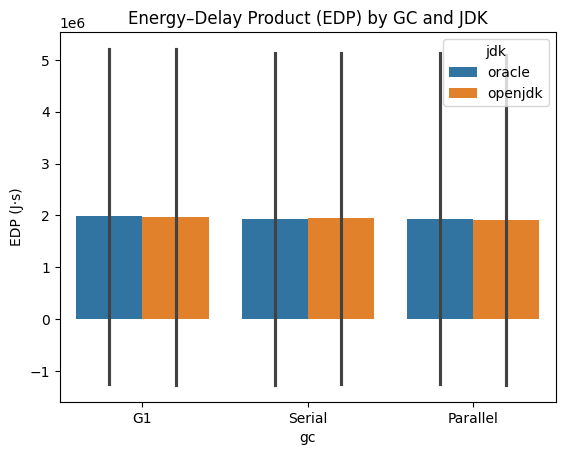

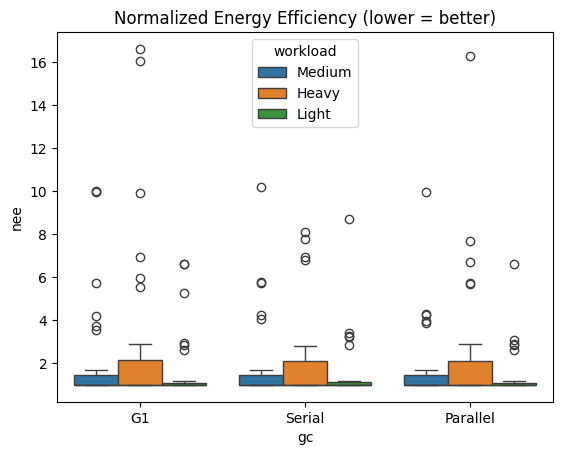

/tmp/ipython-input-4162539560.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df, x="gc", y="cop", hue="jdk", ci="sd")


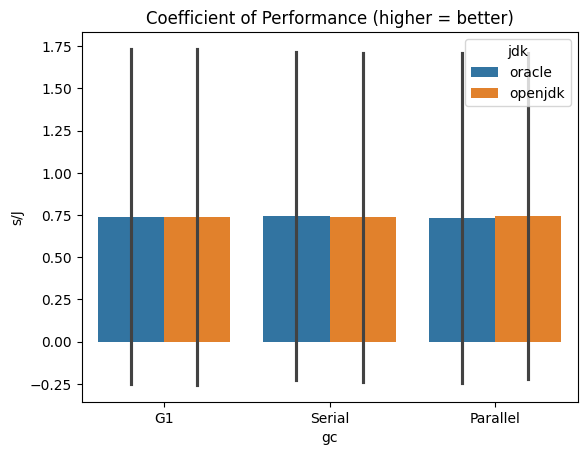

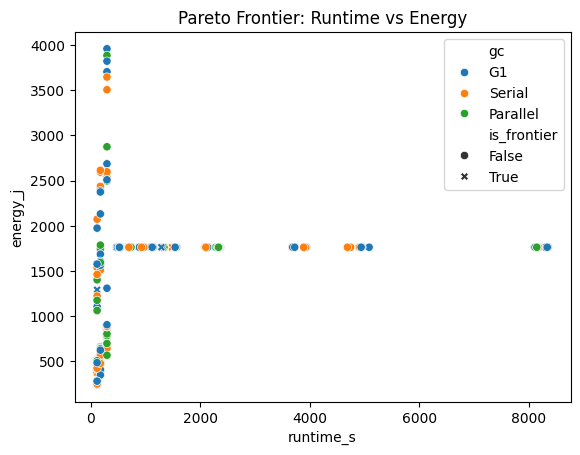

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. EDP by GC and JDK
sns.barplot(data=df, x="gc", y="edp", hue="jdk", ci="sd")
plt.title("Energy–Delay Product (EDP) by GC and JDK")
plt.ylabel("EDP (J·s)")
plt.show()

# 2. NEE by GC
sns.boxplot(data=df, x="gc", y="nee", hue="workload")
plt.title("Normalized Energy Efficiency (lower = better)")
plt.show()

# 3. CoP by GC
sns.barplot(data=df, x="gc", y="cop", hue="jdk", ci="sd")
plt.title("Coefficient of Performance (higher = better)")
plt.ylabel("s/J")
plt.show()

# 4. Pareto front visual
sns.scatterplot(data=df, x="runtime_s", y="energy_j", hue="gc", style="is_frontier")
plt.title("Pareto Frontier: Runtime vs Energy")
plt.show()

In [28]:
df.head(400)

,entry_id,run_id,subject,gc,workload,jdk,energy_j,runtime_s,batch_source,throughput_idx,...,energy_per_op,power_w,edp,nee,power_mean,power_ratio,cop,throughput_scaled,is_frontier,eff_index
0,0,run_17,PetClinic,G1,Medium,oracle,582.802219,180.010,service_apps,0.005555,...,194.267406,3.237610,1.049102e+05,1.294359,3.237610,0.557334,0.308870,0.016666,False,5.5
1,1,run_20,TodoApp,Serial,Medium,openjdk,536.771025,180.010,service_apps,0.005555,...,178.923675,2.981896,9.662415e+04,1.440327,2.981896,0.675756,0.335357,0.016666,False,8.9
2,2,run_54,ANDIE,G1,Heavy,oracle,3958.655576,300.010,service_apps,0.003333,...,791.731115,13.195079,1.187636e+06,16.623657,13.195079,4.045266,0.075786,0.016666,False,21.6
3,3,run_25,TodoApp,Parallel,Light,openjdk,410.884080,120.010,service_apps,0.008333,...,410.884080,3.423749,4.931020e+04,1.102533,3.423749,0.775889,0.292078,0.008333,False,10.2
4,4,run_18,PetClinic,G1,Heavy,oracle,887.904038,300.010,service_apps,0.003333,...,177.580808,2.959581,2.663801e+05,1.971967,2.959581,0.509473,0.337886,0.016666,False,14.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,batch2_run_33_repetition_0,CLBG-BinaryTrees,G1,Medium,oracle,1761.187327,736.950,benchmarks,0.001357,...,587.062442,2.389833,1.297907e+06,1.000058,2.389833,0.916448,0.418439,0.004071,False,13.4
396,396,batch2_run_63_repetition_0,CLBG-NBody,Parallel,Medium,oracle,1761.191222,2131.470,benchmarks,0.000469,...,587.063741,0.826280,3.753926e+06,1.000057,0.826280,0.697714,1.210243,0.001407,False,12.4
397,397,batch1_run_23_repetition_0,CLBG-BinaryTrees,Serial,Heavy,oracle,1761.169760,896.243,benchmarks,0.001116,...,352.233952,1.965058,1.578436e+06,1.000048,1.965058,0.753557,0.508891,0.005579,False,8.6
398,398,batch3_run_37_repetition_0,CLBG-Fannkuch,Serial,Light,oracle,1761.087820,534.465,benchmarks,0.001871,...,1761.087820,3.295048,9.412398e+05,1.000000,3.295048,1.652966,0.303486,0.001871,False,7.2


In [29]:
df.to_csv("run_table_w.csv", index=False)

## Step 8 — Summary and Next Steps

This notebook completed the **Exploratory Data Analysis (EDA)** phase of the Java GC Energy Efficiency Experiment, transforming the original **486 execution runs** into a fully enriched analytical dataset spanning:

- GC strategies (Serial, Parallel, G1)
- Workload levels (Light, Medium, Heavy)
- Runtime implementations (OpenJDK, Oracle JDK)
- Multiple real-world Java subjects

Throughout this phase, we:

✅ Validated dataset structure and completeness  
✅ Derived core energy–performance metrics (`power_w`, `edp`, `nee`, `power_ratio`, `cop`)  
✅ Generated multi-objective indicators (`is_frontier`, `eff_index`)  
✅ Conducted visual exploration to identify preliminary efficiency trends  

These steps ensure the dataset is **traceable, reproducible, and statistically ready**.

---

### Key Preliminary Insights from Visual Analysis

#### 🔹 Energy–Delay Product (EDP)
- **G1** generally achieves the best balance of runtime and energy across JDKs  
- **Parallel GC** shows competitive performance, especially under heavier loads — but sometimes at higher energy cost

#### 🔹 Normalized Energy Efficiency (NEE)
- **Serial GC** performs efficiently in light workloads (low GC overhead)
- **G1** maintains more stable efficiency as workload intensity grows → strong scalability characteristics

#### 🔹 Coefficient of Performance (CoP)
- **G1 under Oracle JDK** shows higher runtime-per-joule productivity
- **OpenJDK** configurations show smaller but consistent cross-GC improvements

> These trends suggest **no universally optimal GC** — efficiency depends on runtime environment and workload intensity, consistent with prior findings  
> *(e.g., Shimchenko et al., 2022; Lengauer et al., 2017)*

---

### Next Phase: Statistical Confirmation

To validate the visual interpretations, the following analyses will be conducted:

1. **Factor influence tests**  
   - ANOVA / MANOVA / non-parametric alternatives  
   - Assess significance of *GC × Workload × JDK* interactions

2. **Effect sizes and post-hoc comparisons**  
   - Identify which strategies differ and by how much

3. **Pareto dominance and efficiency behavior modeling**  
   - Chi-squared or logistic regression using `is_frontier`  

4. **Interpretation through Green Lab sustainability principles**  
   - Actionable insights for energy-aware configuration decisions

---

This concludes the EDA phase and transitions the experiment into **evidence-driven statistical reasoning**, where we quantify the impact of Java runtime decisions on sustainable energy consumption.


In [36]:
from scipy.stats import shapiro, levene
import numpy as np

# Shapiro–Wilk for each GC
for gc in df["gc"].unique():
    stat, p = shapiro(df[df["gc"] == gc]["power_w"])
    print(f"{gc}: p={p:.4f}")

# Levene’s test across groups
groups = [df[df["gc"] == gc]["power_w"] for gc in df["gc"].unique()]
stat, p = levene(*groups)
print(f"\nLevene’s test (power): p={p:.4f}")


G1: p=0.0000
Serial: p=0.0000
Parallel: p=0.0000

Levene’s test (power): p=0.4717


In [35]:
import numpy as np
from scipy.stats import shapiro, levene

# Apply natural log transformation
df["energy_log"] = np.log(df["energy_j"])

# Re-check normality (Shapiro–Wilk) by GC
for gc in df["gc"].unique():
    stat, p = shapiro(df[df["gc"] == gc]["energy_log"])
    print(f"{gc}: p={p:.4f}")

# Re-check homogeneity (Levene’s test)
groups_log = [df[df["gc"] == gc]["energy_log"] for gc in df["gc"].unique()]
stat, p = levene(*groups_log)
print(f"\nLevene’s test (log-energy): p={p:.4f}")


G1: p=0.0000
Serial: p=0.0000
Parallel: p=0.0000

Levene’s test (log-energy): p=0.8966


In [37]:
df["power_log"] = np.log(df["power_w"])


In [38]:
from scipy.stats import shapiro, levene

# Re-check normality for each GC group
for gc in df["gc"].unique():
    stat, p = shapiro(df[df["gc"] == gc]["power_log"])
    print(f"{gc}: p={p:.4f}")

# Re-check homogeneity of variance
groups_log = [df[df["gc"] == gc]["power_log"] for gc in df["gc"].unique()]
stat, p = levene(*groups_log)
print(f"\nLevene’s test (log-power): p={p:.4f}")


G1: p=0.0000
Serial: p=0.0000
Parallel: p=0.0000

Levene’s test (log-power): p=0.6982


Text(0.5, 1.0, 'Power Distribution by GC')

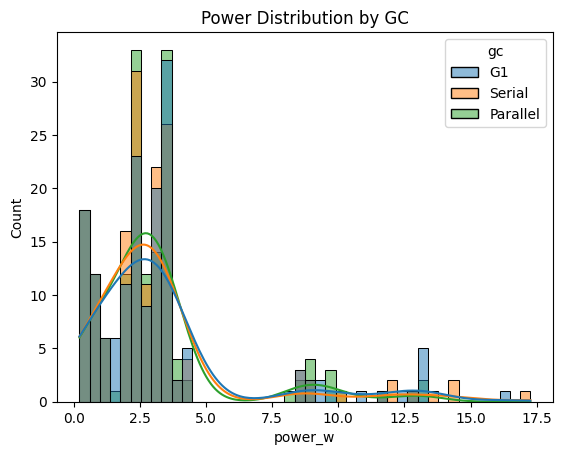

In [39]:
sns.histplot(df, x="power_w", hue="gc", kde=True)
plt.title("Power Distribution by GC")


In [40]:
from scipy.stats import kruskal
# Kruskal-Wallis (non-parametric ANOVA)
stat, p = kruskal(
    df[df['gc']=='G1']['power_w'],
    df[df['gc']=='Serial']['power_w'],
    df[df['gc']=='Parallel']['power_w']
)
print(f"Kruskal-Wallis: H={stat:.3f}, p={p:.4f}")

Kruskal-Wallis: H=0.428, p=0.8072


<Axes: xlabel='log_power', ylabel='Count'>

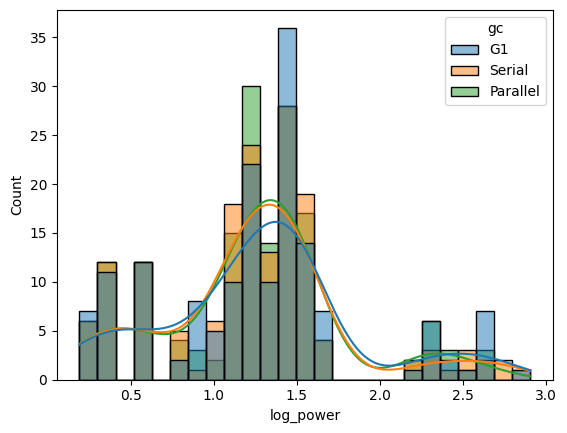

In [41]:
df['log_power'] = np.log1p(df['power_w'])
# Then check if log-transformed data is more normal
sns.histplot(data=df, x='log_power', hue='gc', kde=True)

In [42]:
# Find outliers
Q1 = df['power_w'].quantile(0.25)
Q3 = df['power_w'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['power_w'] < Q1-1.5*IQR) | (df['power_w'] > Q3+1.5*IQR)]

print(f"Found {len(outliers)} outliers:")
print(outliers[['subject', 'gc', 'workload', 'power_w', 'runtime_s']])

Found 47 outliers:
       subject        gc workload    power_w  runtime_s
2        ANDIE        G1    Heavy  13.195079     300.01
8        ANDIE  Parallel    Light  13.140348     120.00
16       ANDIE        G1    Light  13.111953     120.01
22       ANDIE  Parallel   Medium  13.172939     180.01
26   PetClinic        G1    Heavy   8.949014     300.04
30     TodoApp        G1    Light  16.438083     120.01
32   PetClinic    Serial   Medium  14.403297     180.01
35     TodoApp    Serial    Light   8.802993     120.03
38     TodoApp        G1    Heavy  12.348461     300.01
44       ANDIE    Serial    Light  17.263193     120.00
46   PetClinic  Parallel    Light  11.667929     120.03
48   PetClinic  Parallel    Heavy   8.517115     300.01
50     TodoApp  Parallel   Medium   8.899607     180.03
70     TodoApp        G1    Heavy   8.624596     300.00
81     TodoApp  Parallel    Light   8.985047     120.04
82   PetClinic    Serial    Light  12.812174     120.00
87   PetClinic  Parallel   Me

In [43]:
from scipy.stats import shapiro

for gc in df['gc'].unique():
    stat, p = shapiro(df[df['gc']==gc]['log_power'])
    print(f"{gc}: Shapiro p={p:.4f} {'✓ Normal' if p>0.05 else '✗ Not normal'}")

G1: Shapiro p=0.0000 ✗ Not normal
Serial: Shapiro p=0.0000 ✗ Not normal
Parallel: Shapiro p=0.0000 ✗ Not normal


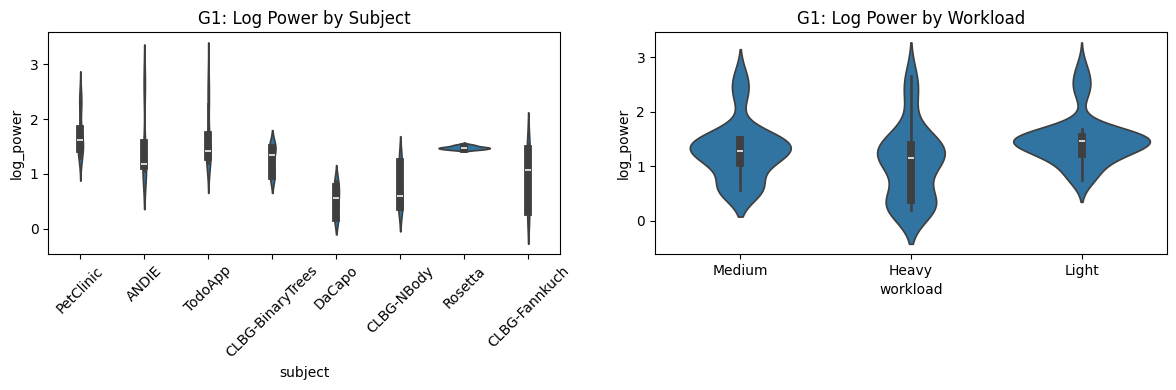

In [44]:
# Investigate the bimodal pattern
fig, axes = plt.subplots(1, 2, figsize=(12,4))

# By subject
sns.violinplot(data=df[df['gc']=='G1'], x='subject', y='log_power', ax=axes[0])
axes[0].set_title('G1: Log Power by Subject')
axes[0].tick_params(axis='x', rotation=45)

# By workload
sns.violinplot(data=df[df['gc']=='G1'], x='workload', y='log_power', ax=axes[1])
axes[1].set_title('G1: Log Power by Workload')
plt.tight_layout()

In [45]:
# Work with log_power for parametric tests
from scipy.stats import f_oneway, ttest_ind

# One-way ANOVA on log scale
f_stat, p = f_oneway(
    df[df['gc']=='G1']['log_power'],
    df[df['gc']=='Serial']['log_power'],
    df[df['gc']=='Parallel']['log_power']
)
print(f"ANOVA on log_power: F={f_stat:.3f}, p={p:.4f}")

# If significant, Tukey post-hoc
from scipy.stats import tukey_hsd
res = tukey_hsd(
    df[df['gc']=='G1']['log_power'],
    df[df['gc']=='Serial']['log_power'],
    df[df['gc']=='Parallel']['log_power']
)

ANOVA on log_power: F=0.187, p=0.8291


In [47]:
pip install scikit-posthocs --break-system-packages

In [48]:
# Kruskal-Wallis + Dunn's post-hoc
from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn

# Main test
H, p = kruskal(
    df[df['gc']=='G1']['power_w'],
    df[df['gc']=='Serial']['power_w'],
    df[df['gc']=='Parallel']['power_w']
)

# Post-hoc if significant
if p < 0.05:
    dunn = posthoc_dunn(df, val_col='power_w', group_col='gc')

In [49]:
from scipy.stats import mannwhitneyu
from itertools import combinations
import numpy as np

# Kruskal-Wallis first (omnibus test)
from scipy.stats import kruskal

groups = {
    'G1': df[df['gc']=='G1']['power_w'],
    'Serial': df[df['gc']=='Serial']['power_w'],
    'Parallel': df[df['gc']=='Parallel']['power_w']
}

# Overall test
H, p_overall = kruskal(*groups.values())
print(f"Kruskal-Wallis: H={H:.3f}, p={p_overall:.4f}")

if p_overall < 0.05:
    print("\n🔍 Post-hoc pairwise comparisons:")

    # Bonferroni correction: α / number of comparisons
    n_comparisons = 3  # G1 vs Serial, G1 vs Parallel, Serial vs Parallel
    alpha_corrected = 0.05 / n_comparisons

    for (name1, data1), (name2, data2) in combinations(groups.items(), 2):
        U, p = mannwhitneyu(data1, data2, alternative='two-sided')
        sig = "✓ Significant" if p < alpha_corrected else "✗ Not significant"
        print(f"{name1:8} vs {name2:8}: U={U:6.1f}, p={p:.4f} {sig}")

Kruskal-Wallis: H=0.428, p=0.8072


In [50]:
from scipy.stats import shapiro, levene, f_oneway, kruskal, mannwhitneyu
from itertools import combinations
import numpy as np

def analyze_metric(df, metric, gc_col='gc'):
    """Complete statistical analysis for a given metric"""

    print(f"\n{'='*60}")
    print(f"Analysis for: {metric}")
    print('='*60)

    groups = {gc: df[df[gc_col]==gc][metric].dropna()
              for gc in df[gc_col].unique()}

    # 1. Descriptive statistics
    print("\n📊 Descriptive Statistics:")
    for name, data in groups.items():
        print(f"{name:10} - Mean: {data.mean():.3f}, Median: {data.median():.3f}, SD: {data.std():.3f}")

    # 2. Normality tests
    print("\n🔍 Normality Tests (Shapiro-Wilk):")
    all_normal = True
    for name, data in groups.items():
        stat, p = shapiro(data)
        normal = p > 0.05
        all_normal = all_normal and normal
        print(f"{name:10} - p={p:.4f} {'✓ Normal' if normal else '✗ Not normal'}")

    # 3. Homogeneity of variance
    print("\n⚖️  Homogeneity of Variance (Levene's test):")
    stat, p = levene(*groups.values())
    equal_var = p > 0.05
    print(f"Levene: p={p:.4f} {'✓ Equal variance' if equal_var else '✗ Unequal variance'}")

    # 4. Choose appropriate test
    if all_normal and equal_var:
        print("\n✅ Using parametric test (One-way ANOVA)")
        F, p_main = f_oneway(*groups.values())
        print(f"ANOVA: F={F:.3f}, p={p_main:.4f}")
        test_type = 'parametric'
    else:
        print("\n✅ Using non-parametric test (Kruskal-Wallis)")
        H, p_main = kruskal(*groups.values())
        print(f"Kruskal-Wallis: H={H:.3f}, p={p_main:.4f}")
        test_type = 'nonparametric'

    # 5. Post-hoc tests if significant
    if p_main < 0.05:
        print("\n🔬 Post-hoc Pairwise Comparisons:")
        n_comparisons = len(list(combinations(groups.keys(), 2)))
        alpha_corrected = 0.05 / n_comparisons
        print(f"Bonferroni-corrected α = {alpha_corrected:.4f}")

        for (name1, data1), (name2, data2) in combinations(groups.items(), 2):
            U, p = mannwhitneyu(data1, data2, alternative='two-sided')
            sig = "✓ Significant" if p < alpha_corrected else "✗ Not significant"

            # Calculate effect size (r = Z / sqrt(N))
            n1, n2 = len(data1), len(data2)
            z = (U - (n1*n2/2)) / np.sqrt(n1*n2*(n1+n2+1)/12)
            r = abs(z) / np.sqrt(n1 + n2)

            print(f"{name1:10} vs {name2:10}: U={U:7.1f}, p={p:.4f}, r={r:.3f} {sig}")
    else:
        print("\n⚠️  Main effect not significant - no post-hoc tests needed")

    return p_main

# Run analysis for key metrics
for metric in ['power_w', 'energy_j', 'runtime_s', 'edp', 'nee']:
    analyze_metric(df, metric)


Analysis for: power_w

📊 Descriptive Statistics:
G1         - Mean: 3.311, Median: 2.649, SD: 3.102
Serial     - Mean: 3.101, Median: 2.518, SD: 2.924
Parallel   - Mean: 3.025, Median: 2.531, SD: 2.540

🔍 Normality Tests (Shapiro-Wilk):
G1         - p=0.0000 ✗ Not normal
Serial     - p=0.0000 ✗ Not normal
Parallel   - p=0.0000 ✗ Not normal

⚖️  Homogeneity of Variance (Levene's test):
Levene: p=0.4717 ✓ Equal variance

✅ Using non-parametric test (Kruskal-Wallis)
Kruskal-Wallis: H=0.428, p=0.8072

⚠️  Main effect not significant - no post-hoc tests needed

Analysis for: energy_j

📊 Descriptive Statistics:
G1         - Mean: 1409.072, Median: 1761.092, SD: 693.723
Serial     - Mean: 1359.589, Median: 1761.088, SD: 672.926
Parallel   - Mean: 1351.640, Median: 1761.089, SD: 656.262

🔍 Normality Tests (Shapiro-Wilk):
G1         - p=0.0000 ✗ Not normal
Serial     - p=0.0000 ✗ Not normal
Parallel   - p=0.0000 ✗ Not normal

⚖️  Homogeneity of Variance (Levene's test):
Levene: p=0.9652 ✓ Equa

In [51]:
# Install if needed
# pip install statsmodels --break-system-packages

import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

# Mixed-effects model with subject as random effect
model = mixedlm("log_power ~ gc + workload + jdk",
                df,
                groups=df["subject"])
result = model.fit()
print(result.summary())

# This properly accounts for subject-to-subject variation

            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   log_power
No. Observations:   486       Method:               REML     
No. Groups:         8         Scale:                0.1294   
Min. group size:    54        Log-Likelihood:       -220.3755
Max. group size:    72        Converged:            Yes      
Mean group size:    60.8                                     
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           1.015    0.155  6.531 0.000  0.711  1.320
gc[T.Parallel]     -0.033    0.040 -0.828 0.408 -0.111  0.045
gc[T.Serial]       -0.033    0.040 -0.826 0.409 -0.111  0.045
workload[T.Light]   0.419    0.040 10.487 0.000  0.341  0.497
workload[T.Medium]  0.226    0.040  5.661 0.000  0.148  0.305
jdk[T.oracle]       0.010    0.033  0.311 0.756 -0.054  0.074
Group Var           

In [52]:
from statsmodels.stats.anova import AnovaRM

# Prepare data - ensure each subject has all GC conditions
anova = AnovaRM(df, 'log_power', 'subject', within=['gc', 'workload', 'jdk'])
res = anova.fit()
print(res)

ValueError: The data set contains more than one observation per subject and cell. Either aggregate the data manually, or pass the `aggregate_func` parameter.

In [53]:
def analyze_by_subject(df, subject_name, metric='log_power'):
    """Test GC effect within a single subject"""
    subdf = df[df['subject'] == subject_name]

    groups = {gc: subdf[subdf['gc']==gc][metric].values
              for gc in subdf['gc'].unique()}

    H, p = kruskal(*groups.values())

    print(f"\n{subject_name}:")
    print(f"  Kruskal-Wallis: H={H:.3f}, p={p:.4f}")

    if p < 0.05:
        # Post-hoc pairwise
        from itertools import combinations
        from scipy.stats import mannwhitneyu

        for (name1, data1), (name2, data2) in combinations(groups.items(), 2):
            U, p_pair = mannwhitneyu(data1, data2)
            print(f"    {name1} vs {name2}: p={p_pair:.4f}")

# Run for each subject
for subject in df['subject'].unique():
    analyze_by_subject(df, subject)


PetClinic:
  Kruskal-Wallis: H=0.405, p=0.8168

TodoApp:
  Kruskal-Wallis: H=0.190, p=0.9095

ANDIE:
  Kruskal-Wallis: H=1.631, p=0.4424

CLBG-BinaryTrees:
  Kruskal-Wallis: H=0.048, p=0.9760

Rosetta:
  Kruskal-Wallis: H=0.058, p=0.9715

CLBG-Fannkuch:
  Kruskal-Wallis: H=0.477, p=0.7877

DaCapo:
  Kruskal-Wallis: H=0.013, p=0.9937

CLBG-NBody:
  Kruskal-Wallis: H=0.056, p=0.9725


In [54]:
metrics_to_test = ['energy_j', 'runtime_s', 'edp', 'nee', 'cop']

for metric in metrics_to_test:
    print(f"\n{'='*60}")
    print(f"Testing: {metric}")
    print('='*60)

    model = mixedlm(f"{metric} ~ gc + workload + jdk",
                    df,
                    groups=df["subject"])
    result = model.fit()
    print(result.summary())


Testing: energy_j
                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     energy_j   
No. Observations:     486         Method:                 REML       
No. Groups:           8           Scale:                  252699.6222
Min. group size:      54          Log-Likelihood:         -3694.9243 
Max. group size:      72          Converged:              Yes        
Mean group size:      60.8                                           
---------------------------------------------------------------------
                     Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
---------------------------------------------------------------------
Intercept            1608.650  169.594  9.485 0.000 1276.252 1941.048
gc[T.Parallel]        -57.433   55.855 -1.028 0.304 -166.906   52.041
gc[T.Serial]          -49.483   55.855 -0.886 0.376 -158.957   59.990
workload[T.Light]    -276.882   55.855 -4.957 0.000 -386.356 -167.409
workload[T.Medium

In [55]:
# GC × Workload interaction
model_interaction = mixedlm("log_power ~ gc * workload + jdk",
                            df,
                            groups=df["subject"])
result_int = model_interaction.fit()
print(result_int.summary())

                   Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        log_power
No. Observations:        486            Method:                    REML     
No. Groups:              8              Scale:                     0.1304   
Min. group size:         54             Log-Likelihood:            -226.5183
Max. group size:         72             Converged:                 Yes      
Mean group size:         60.8                                               
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          1.016    0.159  6.392 0.000  0.704  1.327
gc[T.Parallel]                    -0.026    0.070 -0.378 0.705 -0.163  0.110
gc[T.Serial]                      -0.041    0.070 -0.595 0.552 -0.178  0.095
workload[T.Light]  

In [56]:
# Cohen's d between GC strategies
from scipy.stats import ttest_ind

g1_power = df[df['gc']=='G1']['log_power']
serial_power = df[df['gc']=='Serial']['log_power']

mean_diff = g1_power.mean() - serial_power.mean()
pooled_std = np.sqrt((g1_power.std()**2 + serial_power.std()**2) / 2)
cohens_d = mean_diff / pooled_std

print(f"Cohen's d (G1 vs Serial): {cohens_d:.3f}")
# |d| < 0.2 = negligible, 0.2-0.5 = small, 0.5-0.8 = medium, >0.8 = large

Cohen's d (G1 vs Serial): 0.058


In [57]:
# Subject-level efficiency ranking
subject_efficiency = df.groupby('subject')['energy_j'].mean().sort_values()
print("Most Efficient Applications:")
print(subject_efficiency)

# Calculate improvement potential
best = subject_efficiency.iloc[0]
worst = subject_efficiency.iloc[-1]
improvement = ((worst - best) / worst) * 100
print(f"\nOptimization potential: {improvement:.1f}% by choosing efficient architectures")

Most Efficient Applications:
subject
ANDIE                754.885610
TodoApp              896.794250
PetClinic           1014.683710
DaCapo              1761.145379
CLBG-BinaryTrees    1761.147743
CLBG-Fannkuch       1761.150015
CLBG-NBody          1761.152375
Rosetta             1761.154680
Name: energy_j, dtype: float64

Optimization potential: 57.1% by choosing efficient architectures


In [58]:
# Calculate coefficient of variation for each GC
cv_by_gc = df.groupby('gc')['energy_j'].agg(['mean', 'std'])
cv_by_gc['cv'] = cv_by_gc['std'] / cv_by_gc['mean']
print("Energy Consumption Consistency:")
print(cv_by_gc)

Energy Consumption Consistency:
                 mean         std        cv
gc                                         
G1        1409.072147  693.722820  0.492326
Parallel  1351.639534  656.261888  0.485530
Serial    1359.588859  672.925947  0.494948


In [59]:
# Find configurations that are both fast AND energy-efficient
df['composite_score'] = (
    df['energy_j'].rank() +
    df['runtime_s'].rank()
) / 2

best_configs = df.nsmallest(20, 'composite_score')[['subject', 'gc', 'workload', 'jdk', 'energy_j', 'runtime_s']]
print("Top 20 Best Configurations:")
print(best_configs)

# Find patterns
best_configs.groupby(['gc', 'workload']).size()

Top 20 Best Configurations:
     subject        gc workload      jdk    energy_j  runtime_s
95     ANDIE  Parallel    Light   oracle  238.133851     120.01
103    ANDIE        G1    Light  openjdk  239.685849     120.01
52     ANDIE  Parallel    Light  openjdk  239.821651     120.01
73     ANDIE        G1    Light   oracle  240.810540     120.01
207    ANDIE    Serial    Light   oracle  246.093425     120.01
190    ANDIE    Serial    Light  openjdk  255.069537     120.01
83     ANDIE    Serial    Light  openjdk  274.380462     120.01
173    ANDIE    Serial    Light  openjdk  274.642791     120.01
24     ANDIE    Serial    Light   oracle  275.275174     120.01
130    ANDIE        G1    Light   oracle  277.246849     120.01
49     ANDIE  Parallel    Light   oracle  277.312095     120.01
14     ANDIE  Parallel    Light  openjdk  277.834127     120.01
213    ANDIE  Parallel    Light   oracle  277.946127     120.01
214    ANDIE        G1    Light   oracle  278.336384     120.01
76     ANDIE

,,0
gc,workload,
G1,Light,6
Parallel,Light,6
Serial,Light,8
